***
# 3. Reproduction d'une figure des auteurs
***

Maintenant que nous disposons de tous les outils essentiels pour comprendre la méthode, il serait intéressant de reconstruire l'exemple illustré dans la figure 3 du papier de Dedalus. 


![Figure 3 du papier](Images/figure.png)

> K J Burns, G M Vasil, J S Oishi, D Lecoanet, B P Brown, "Dedalus: A Flexible Framework for Numerical Simulations with Spectral Methods," Physical Review Research, vol. 2, no. 2, Apr. 2020.

La reproduction de cet exemple permet de synthétiser les parties une et deux de ce projet, tout en examinant une propriété particulière. Nous pourrons observer que selon la manière dont nous disposons les différentes matrices en bloc et choisissons la position des conditions aux limites, la forme finale de la matrice à inverser ne sera pas exactement la même.

**Cette figure 3 représente les étapes conceptuelles dans la construction d'une matrice pour la discrétisation de Chebyshev de l'équation de Poisson avec des conditions aux limites de Dirichlet et Neumann**. Le problème est défini par l'équation suivante :

$$ \frac{\partial^2 u}{\partial x^2} = f(x), \quad u(-1) = 0, \quad \frac{\partial u}{\partial x}(1) = 0. $$

Une observation immédiate est que cette équation est exactement la même que celle étudiée dans la partie deux de notre projet. Cependant, comme nous pouvons le constater dans la figure ci-dessous (issue du code à la fin de la section "Renversement de produit de Kronecker"), les résultats finaux ne sont pas exactement identiques.

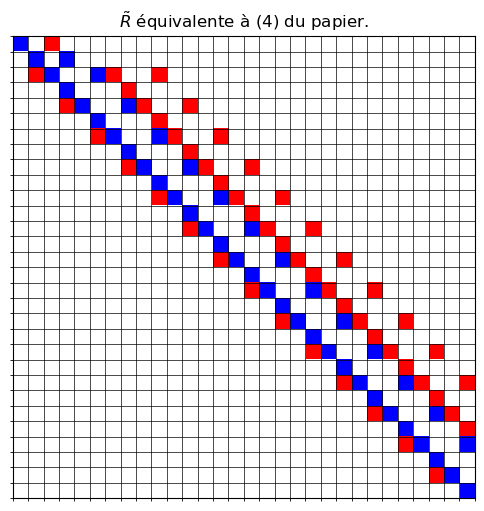

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 15

# Définition des polynômes de Chebysev du premier ordre (T_n)
def Tn(n, x):
    return np.cos(n * np.arccos(x))

# Définition des polynômes de Chebysev du second ordre (U_n)
def Un(n, x):
    numerator = np.sin((n + 1) * np.arccos(x))
    denominator = np.sin(np.arccos(x))
    return numerator / denominator

# Définition des produits scalaires
def inner_product_0(f, g):
    integrand = lambda x: f(x) * g(x) / np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

def inner_product_2(f, g):
    integrand = lambda x: f(x) * g(x) * np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

# Calcul des dérivées des polynômes de Chebysev du premier ordre
def dTn_dx(n, x):
    return n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x**2)

# Calcul des polynomes de Dirichlet
def Dn(n, x):
    if n == 0 or n == 1:
        return Tn(n, x)
    elif n > 1:
        return Tn(n, x) - Tn(n-2, x)
        
# Et de leurs dérivés 
def dDn_dx(n, x):
    if n == 0 or n == 1:
        return dTn_dx(n, x)
    elif n > 1:
        return dTn_dx(n, x) - dTn_dx(n-2, x)

# Calcul des coefficents de la décomposition
Dtau = np.zeros((2*N, 2*N))

for i in range(N-1):
    for j in range(N):
        f_Ui = lambda x: Un(i, x)
        f_Dj = lambda x: Dn(j, x)
        f_dD = lambda x: dDn_dx(j, x)

        Lij = inner_product_2(f_Ui, f_dD)
        Dtau[i+1, j] = Lij # +1 dû à la méthode tau qui décale et supprime une ligne 
        Dtau[N+i+1, N+j] = Lij # +1 dû à la méthode tau qui décale et supprime une ligne 

        Dtau[i+1, N+j] = -inner_product_2(f_Ui, f_Dj) # +1 dû à la méthode tau qui décale et supprime une ligne 
        
# Ajout de la condition initiale par la méthode tau
#D_n(1) = 1 pour n = 0 ou 1
#D_n(-1) = 1 pour n = 0 et - 1 pour n = 1
Dtau[0, 0] = 1 
Dtau[0, 1] = -1 
Dtau[N,N] = 1 
Dtau[N,N+ 1] = 1 

### Calcul du renveserment de Kronecker 

# Dtau sous forme de bloc
D11 = Dtau[:N,:N]
D12 = Dtau[:N,N:]
D21 = Dtau[N:,:N]
D22 = Dtau[N:,N:]

# matrice élemntaire

def matrice_elementaire(i, j, taille):
    E = np.zeros((taille, taille))
    E[i, j] = 1
    return E
    
E11 = matrice_elementaire(0, 0, 2)
E12 = matrice_elementaire(0, 1, 2)
E21 = matrice_elementaire(1, 0, 2)
E22 = matrice_elementaire(1, 1, 2)

# calcul de DtauTilde
DtauTilde = np.zeros((2*N, 2*N))

DtauTilde = np.kron(D11,E11) + np.kron(D12,E12) + np.kron(D21,E21) + np.kron(D22,E22) 


def plot_L(ax, matrix, title, epsilon=1e-5):
    colors = np.zeros_like(matrix, dtype=np.dtype((float, 4)))  # RGBA

    for i in range(2*N):
        for j in range(2*N):
            value = matrix[i, j]
            if abs(value) < epsilon:
                colors[i, j] = [1, 1, 1, 1]  # Blanc pour les valeurs proches de zéro
            elif value > 0:
                colors[i, j] = [0, 0, 1, 1]  # Bleu pour les valeurs positives
            else:
                colors[i, j] = [1, 0, 0, 1]  # Rouge pour les valeurs négatives

    ax.imshow(colors, interpolation='none')
    # Contour noir
    ax.contour(colors[:, :, 0], levels=[2], colors='black', linewidths=2)
    
    # Grille
    ax.set_xticks(np.arange(0, 2*N, 1))
    ax.set_yticks(np.arange(0, 2*N, 1))
    ax.set_xticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)
    ax.tick_params(which="major", size=0)  # Désactiver les ticks majeurs

    
    ax.set_xticklabels([])  # Désactiver les labels des axes x
    ax.set_yticklabels([])  # Désactiver les labels des axes y

    ax.set_title(title)


# Création de sous-graphiques
fig = plt.figure(figsize=(6, 6))
axs = fig.add_subplot(1, 1, 1)

# Affichage des matrices
plot_L(axs, DtauTilde, r'$\tilde{R}$ équivalente à (4) du papier.')

L'une des raisons pour lesquelles les résultats diffèrent réside dans la manière dont la matrice du problème a été formulée. Initialement, elle n'a pas été écrite comme suit :

$$
\begin{bmatrix}
\frac{\partial}{\partial x} & -1 \\
0 & \frac{\partial}{\partial x}
\end{bmatrix}
\begin{bmatrix}
u \\
u_x
\end{bmatrix}
=\begin{bmatrix}
0 \\
f(x)
\end{bmatrix}.
$$

Cependant, elle a été exprimée de la manière suivante :

$$
\begin{bmatrix}
0 & \frac{\partial}{\partial x}\\
\frac{\partial}{\partial x} & -1 
\end{bmatrix}
\begin{bmatrix}
u_x \\
u
\end{bmatrix}
=\begin{bmatrix}
f(x) \\
0
\end{bmatrix}.
$$

De plus, le choix de la position des conditions aux limites dans la matrice a également été différent.

L'objectif de cette section est donc, tout d'abord, de reconstruire ce résultat, ce qui constituera un récapitulatif des concepts abordés jusqu'à présent. Ensuite, nous chercherons à comprendre en quoi les différences par rapport à ce que nous avons examiné précédemment peuvent influencer l'efficacité de notre approche.


Pour cela, considérons $L_1$ comme la matrice du problème telle que décrite dans la deuxième partie de ce projet, et $L_2$ comme la matrice du problème selon la formulation des auteurs dans le papier, définies comme suit : 
$$
L_1 = \begin{bmatrix}
\frac{\partial}{\partial x} & -1 \\
0 & \frac{\partial}{\partial x}
\end{bmatrix}
\quad \text{et}\quad L_2 = \begin{bmatrix}
0 & \frac{\partial}{\partial x}\\
\frac{\partial}{\partial x} & -1 
\end{bmatrix}.
$$

**À chaque étape, nous suivrons la procédure des auteurs, c'est-à-dire la transformation de $L_2$, et nous comparerons les résultats avec ce que nous aurions obtenu en utilisant la matrice $L_1$.**

Il est à noter que les équations et les polynômes utilisés restent les mêmes, et pour plus de détails, nous pouvons nous référer aux deux premières parties de ce projet.


***
**Remarque : Importance de cette partie**

Cette partie revêt une importance plus nuancée dans le projet. Elle offre une opportunité de récapituler les concepts abordés jusqu'à présent tout en mettant en lumière les subtilités présentes dans les choix de construction de la méthode. Bien que ces nuances ne soient pas cruciales pour la fondation de la méthode, elles contribuent à une compréhension approfondie et à une appréciation des différentes approches possibles. Cela permettra, en fin de compte, une évaluation plus fine de l'impact de ces choix sur l'efficacité globale de la méthode.
***

# 1. Construction naïve de la méthode spectrale

La première sous-figure de la figure 3 du papier, intitulée "T-to-T equation blocks", illustre la première version naïve que l'on aurait pu anticiper d'une méthode spectrale classique. Il s'agit de la décomposition et de la projection dans une unique base : les polynômes de Chebyshev du premier ordre, notés $T_n(x)$.

Les lignes de code suivantes permettent de reproduire ce résultat.

/var/folders/9f/0jrfgj_j4z3__3_zptttt5280000gn/T/ipykernel_81584/2734386452.py:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(integrand, -1, 1)


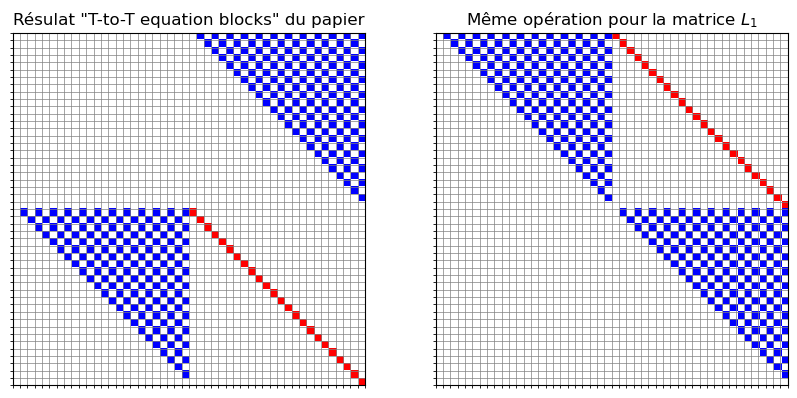

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 24

# Définition des polynômes de Chebysev du premier ordre (T_n)
def Tn(n, x):
    return np.cos(n * np.arccos(x))

# Définition des polynômes de Chebysev du second ordre (U_n)
def Un(n, x):
    numerator = np.sin((n + 1) * np.arccos(x))
    denominator = np.sin(np.arccos(x))
    return numerator / denominator

# Définition des produits scalaires
def inner_product_1(f, g):
    integrand = lambda x: f(x) * g(x) / np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

def inner_product_2(f, g):
    integrand = lambda x: f(x) * g(x) * np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

# Calcul des dérivées des polynômes de Chebysev du premier ordre
def dTn_dx(n, x):
    return n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x**2)


# Calcul des coefficents de la décomposition
TtoT = np.zeros((2*N, 2*N))

L1 = np.zeros((2*N, 2*N))

for i in range(N):
    for j in range(N):
        f_Ti = lambda x: Tn(i, x)
        f_Tj = lambda x: Tn(j, x)
        f_dT = lambda x: dTn_dx(j, x)

        psD = inner_product_1(f_Ti, f_dT)
        psV = inner_product_1(f_Ti, f_Tj)
        
        TtoT[N+i, j] = psD
        TtoT[i, N+j] = psD
        
        TtoT[N+i, N+j] = -psV

        L1[i, j] = psD
        L1[N+i, N+j] = psD
        
        L1[i, N+j] = -psV

def plot_L(ax, matrix, title, epsilon=1e-5):
    colors = np.zeros_like(matrix, dtype=np.dtype((float, 4)))  # RGBA

    for i in range(2*N):
        for j in range(2*N):
            value = matrix[i, j]
            if abs(value) < epsilon:
                colors[i, j] = [1, 1, 1, 1]  # Blanc pour les valeurs proches de zéro
            elif value > 0:
                colors[i, j] = [0, 0, 1, 1]  # Bleu pour les valeurs positives
            else:
                colors[i, j] = [1, 0, 0, 1]  # Rouge pour les valeurs négatives

    ax.imshow(colors, interpolation='none')
    # Contour noir
    ax.contour(colors[:, :, 0], levels=[2], colors='black', linewidths=2)
    
    # Grille
    ax.set_xticks(np.arange(0, 2*N, 1))
    ax.set_yticks(np.arange(0, 2*N, 1))
    ax.set_xticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
    ax.tick_params(which="major", size=0)  # Désactiver les ticks majeurs

    
    ax.set_xticklabels([])  # Désactiver les labels des axes x
    ax.set_yticklabels([])  # Désactiver les labels des axes y

    ax.set_title(title)

# Création de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(10, 10))


# Affichage des matrices
plot_L(axs[0], TtoT, r'Résulat "T-to-T equation blocks" du papier')
plot_L(axs[1], L1, r'Même opération pour la matrice $L_1$')



Notons d'abord une première différence par rapport à notre approche précédente : si nous n'écrivons pas la décomposition de la même manière, les blocs ne se positionnent pas exactement aux mêmes emplacements. Il est crucial de souligner que cette variation n'affecte en rien les résultats obtenus.

> Comme discuté dans la première partie de ce projet, cette méthode conduit à des matrices denses qui ne sont pas efficaces à inverser. Par conséquent, il est nécessaire de passer à la méthode de Galerkin.

# 2. Construction de la méthode de Galerkin associée à la méthode tau

La deuxième sous-figure, intitulée "T-to-U conversion, BCs," représente la transition de la méthode spectrale classique à la méthode de Galerkin associée à la méthode tau, avec les paramètres suivants :

- base d'essaie : $|\phi_n(x)\rangle = T_n(x)$ avec son produit scalaire $ \langle ., . \rangle_1$,
- base de test : $|\psi_n(x)\rangle = U_n(x)$ avec son produit scalaire $ \langle ., . \rangle_2$.

Les lignes de code suivantes permettent de reproduire ce résultat.


/var/folders/9f/0jrfgj_j4z3__3_zptttt5280000gn/T/ipykernel_81584/1280717667.py:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(integrand, -1, 1)


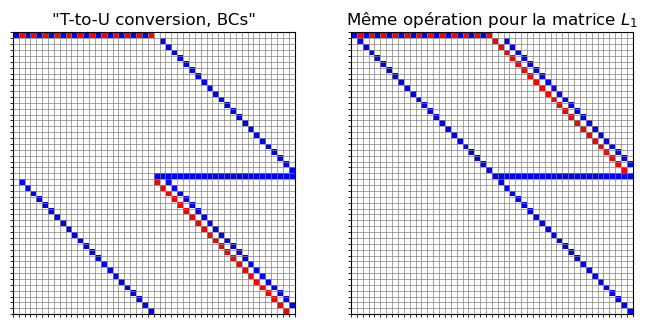

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 24

# Définition des polynômes de Chebysev du premier ordre (T_n)
def Tn(n, x):
    return np.cos(n * np.arccos(x))

# Définition des polynômes de Chebysev du second ordre (U_n)
def Un(n, x):
    numerator = np.sin((n + 1) * np.arccos(x))
    denominator = np.sin(np.arccos(x))
    return numerator / denominator

# Définition des produits scalaires
def inner_product_1(f, g):
    integrand = lambda x: f(x) * g(x) / np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

def inner_product_2(f, g):
    integrand = lambda x: f(x) * g(x) * np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

# Calcul des dérivées des polynômes de Chebysev du premier ordre
def dTn_dx(n, x):
    return n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x**2)


# Calcul des coefficents de la décomposition
TtoT = np.zeros((2*N, 2*N))

L1 = np.zeros((2*N, 2*N))

for i in range(N-1):
    for j in range(N):
        f_Ui = lambda x: Un(i, x)
        f_Tj = lambda x: Tn(j, x)
        f_dT = lambda x: dTn_dx(j, x)

        psD = inner_product_2(f_Ui, f_dT)
        psV = inner_product_2(f_Ui, f_Tj)
        TtoT[N+i+1, j] = psD # +1 dû à la méthode tau qui décale et supprime une ligne 
        TtoT[i+1, N+j] = psD # +1 dû à la méthode tau qui décale et supprime une ligne 
        
        TtoT[N+i+1, N+j] = -psV

        L1[i+1, j] = psD
        L1[N+i+1, N+j] = psD
        
        L1[i+1, N+j] = -psV


# Conditions aux limites
for i in range(N):
    TtoT[0, i] = (-1)**i
    TtoT[N, N+i] = 1
    L1[0, i] = (-1)**i
    L1[N, N+i] = 1

def plot_L(ax, matrix, title, epsilon=1e-5):
    colors = np.zeros_like(matrix, dtype=np.dtype((float, 4)))  # RGBA

    for i in range(2*N):
        for j in range(2*N):
            value = matrix[i, j]
            if abs(value) < epsilon:
                colors[i, j] = [1, 1, 1, 1]  # Blanc pour les valeurs proches de zéro
            elif value > 0:
                colors[i, j] = [0, 0, 1, 1]  # Bleu pour les valeurs positives
            else:
                colors[i, j] = [1, 0, 0, 1]  # Rouge pour les valeurs négatives

    ax.imshow(colors, interpolation='none')
    # Contour noir
    ax.contour(colors[:, :, 0], levels=[2], colors='black', linewidths=2)
    
    # Grille
    ax.set_xticks(np.arange(0, 2*N, 1))
    ax.set_yticks(np.arange(0, 2*N, 1))
    ax.set_xticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
    ax.tick_params(which="major", size=0)  # Désactiver les ticks majeurs

    
    ax.set_xticklabels([])  # Désactiver les labels des axes x
    ax.set_yticklabels([])  # Désactiver les labels des axes y

    ax.set_title(title)

# Création de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(8, 8))


# Affichage des matrices
plot_L(axs[0], TtoT, r'"T-to-U conversion, BCs"')
plot_L(axs[1], L1, r'Même opération pour la matrice $L_1$')

Observons maintenant que le positionnement des blocs influence la structure de la matrice globale une fois que les conditions aux limites sont ajoutées. Par exemple, dans notre cas, un bloc est entièrement nul, tandis que dans leur approche, aucun bloc n'est nul.

> Comme évoqué dans la deuxième partie de ce projet, l'incorporation des conditions aux limites entraîne la présence de matrices denses. Afin de remédier à cela, nous appliquerons la technique de préconditionnement de Dirichlet pour retrouver des blocs à bandes.

# 3. Construction de blocs à bandes par le préconditionnement de Dirichlet

La troisième sous-figure, intitulée "Dirichlet recombination", représente la transition de l'implémentation brutale des conditions aux limites par la méthode tau à une mise en œuvre plus subtile en ajoutant le préconditionnement de Dirichlet à la méthode tau, utilisant comme base d'essai les polynômes $D_n$.

Les lignes de code ci-dessous permettent de reproduire ce résultat.

/var/folders/9f/0jrfgj_j4z3__3_zptttt5280000gn/T/ipykernel_81584/3912922223.py:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(integrand, -1, 1)


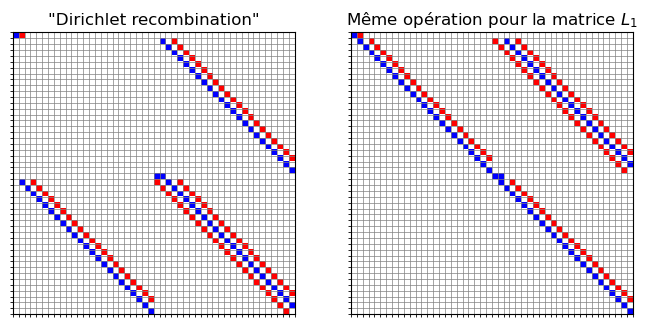

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 24

# Définition des polynômes de Chebysev du premier ordre (T_n)
def Tn(n, x):
    return np.cos(n * np.arccos(x))

# Définition des polynômes de Chebysev du second ordre (U_n)
def Un(n, x):
    numerator = np.sin((n + 1) * np.arccos(x))
    denominator = np.sin(np.arccos(x))
    return numerator / denominator

# Définition des produits scalaires
def inner_product_1(f, g):
    integrand = lambda x: f(x) * g(x) / np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

def inner_product_2(f, g):
    integrand = lambda x: f(x) * g(x) * np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

# Calcul des dérivées des polynômes de Chebysev du premier ordre
def dTn_dx(n, x):
    return n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x**2)

# Calcul des polynomes de Dirichlet
def Dn(n, x):
    if n == 0 or n == 1:
        return Tn(n, x)
    elif n > 1:
        return Tn(n, x) - Tn(n-2, x)
        
# Et de leurs dérivés 
def dDn_dx(n, x):
    if n == 0 or n == 1:
        return dTn_dx(n, x)
    elif n > 1:
        return dTn_dx(n, x) - dTn_dx(n-2, x)


# Calcul des coefficents de la décomposition
TtoT = np.zeros((2*N, 2*N))
L1 = np.zeros((2*N, 2*N))

for i in range(N-1):
    for j in range(N):
        f_Ui = lambda x: Un(i, x)
        f_Dj = lambda x: Dn(j, x)
        f_dD = lambda x: dDn_dx(j, x)

        psD = inner_product_2(f_Ui, f_dD)
        psV = inner_product_2(f_Ui, f_Dj)
        TtoT[N+i+1, j] = psD # +1 dû à la méthode tau qui décale et supprime une ligne 
        TtoT[i+1, N+j] = psD # +1 dû à la méthode tau qui décale et supprime une ligne 
        
        TtoT[N+i+1, N+j] = -psV

        L1[i+1, j] = psD
        L1[N+i+1, N+j] = psD
        
        L1[i+1, N+j] = -psV


# Conditions aux limites
for i in range(2):
    TtoT[0, i] = (-1)**i
    TtoT[N, N+i] = 1
    L1[0, i] = (-1)**i
    L1[N, N+i] = 1

def plot_L(ax, matrix, title, epsilon=1e-5):
    colors = np.zeros_like(matrix, dtype=np.dtype((float, 4)))  # RGBA

    for i in range(2*N):
        for j in range(2*N):
            value = matrix[i, j]
            if abs(value) < epsilon:
                colors[i, j] = [1, 1, 1, 1]  # Blanc pour les valeurs proches de zéro
            elif value > 0:
                colors[i, j] = [0, 0, 1, 1]  # Bleu pour les valeurs positives
            else:
                colors[i, j] = [1, 0, 0, 1]  # Rouge pour les valeurs négatives

    ax.imshow(colors, interpolation='none')
    # Contour noir
    ax.contour(colors[:, :, 0], levels=[2], colors='black', linewidths=2)
    
    # Grille
    ax.set_xticks(np.arange(0, 2*N, 1))
    ax.set_yticks(np.arange(0, 2*N, 1))
    ax.set_xticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
    ax.tick_params(which="major", size=0)  # Désactiver les ticks majeurs

    
    ax.set_xticklabels([])  # Désactiver les labels des axes x
    ax.set_yticklabels([])  # Désactiver les labels des axes y

    ax.set_title(title)

# Création de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(8, 8))


# Affichage des matrices
plot_L(axs[0], TtoT, r'"Dirichlet recombination"')
plot_L(axs[1], L1, r'Même opération pour la matrice $L_1$')

Nous obtenons ainsi des matrices à bande par bloc. Tout comme dans la figure précédente, bien que nous partions de la même équation de base, les choix de blocs entraînent des résultats légèrement différents. Une certaine symétrie est plus perceptible de leur côté, tandis que du côté du choix $L_1$, on observe la présence d'une matrice bloc nulle.

> Enfin, étant donné que les blocs non nuls ne se trouvent pas uniquement sur la diagonale principale, l'utilisation de la méthode du renversement du produit de Kronecker est nécessaire.

# 4. Construction d'une matrice globale à bande par le renversement du produit de Kronecker

La quatrième sous-figure, intitulée "Reversed Kronecker", représente finalement la dernière étape de renversement du produit de Kronecker afin d'obtenir une matrice globalement à bande.

Les lignes de code ci-dessous permettent de reproduire ce résultat.

/var/folders/9f/0jrfgj_j4z3__3_zptttt5280000gn/T/ipykernel_81584/999536045.py:26: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(integrand, -1, 1)


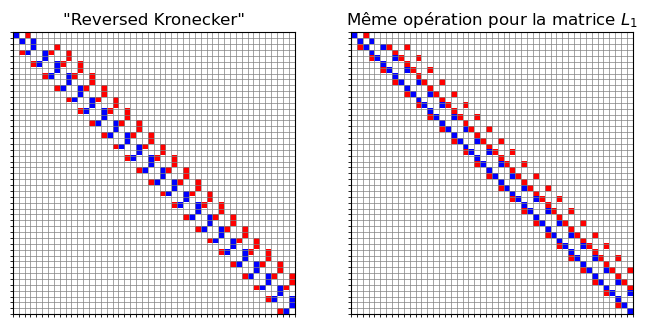

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 24

# Définition des polynômes de Chebysev du premier ordre (T_n)
def Tn(n, x):
    return np.cos(n * np.arccos(x))

# Définition des polynômes de Chebysev du second ordre (U_n)
def Un(n, x):
    numerator = np.sin((n + 1) * np.arccos(x))
    denominator = np.sin(np.arccos(x))
    return numerator / denominator

# Définition des produits scalaires
def inner_product_1(f, g):
    integrand = lambda x: f(x) * g(x) / np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

def inner_product_2(f, g):
    integrand = lambda x: f(x) * g(x) * np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

# Calcul des dérivées des polynômes de Chebysev du premier ordre
def dTn_dx(n, x):
    return n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x**2)

# Calcul des polynomes de Dirichlet
def Dn(n, x):
    if n == 0 or n == 1:
        return Tn(n, x)
    elif n > 1:
        return Tn(n, x) - Tn(n-2, x)
        
# Et de leurs dérivés 
def dDn_dx(n, x):
    if n == 0 or n == 1:
        return dTn_dx(n, x)
    elif n > 1:
        return dTn_dx(n, x) - dTn_dx(n-2, x)


# Calcul des coefficents de la décomposition
TtoT = np.zeros((2*N, 2*N))
L1 = np.zeros((2*N, 2*N))

for i in range(N-1):
    for j in range(N):
        f_Ui = lambda x: Un(i, x)
        f_Dj = lambda x: Dn(j, x)
        f_dD = lambda x: dDn_dx(j, x)

        psD = inner_product_2(f_Ui, f_dD)
        psV = inner_product_2(f_Ui, f_Dj)
        TtoT[N+i+1, j] = psD # +1 dû à la méthode tau qui décale et supprime une ligne 
        TtoT[i+1, N+j] = psD # +1 dû à la méthode tau qui décale et supprime une ligne 
        
        TtoT[N+i+1, N+j] = -psV

        L1[i+1, j] = psD
        L1[N+i+1, N+j] = psD
        
        L1[i+1, N+j] = -psV

# Conditions aux limites
for i in range(2):
    TtoT[0, i] = (-1)**i
    TtoT[N, N+i] = 1
    L1[0, i] = (-1)**i
    L1[N, N+i] = 1

### Calcul du renveserment de Kronecker 

# TtoT sous forme de bloc
D11 = TtoT[:N,:N]
D12 = TtoT[:N,N:]
D21 = TtoT[N:,:N]
D22 = TtoT[N:,N:]

# L1 sous forme de bloc
L11 = L1[:N,:N]
L12 = L1[:N,N:]
L21 = L1[N:,:N]
L22 = L1[N:,N:]

# matrice élemntaire

def matrice_elementaire(i, j, taille):
    E = np.zeros((taille, taille))
    E[i, j] = 1
    return E
    
E11 = matrice_elementaire(0, 0, 2)
E12 = matrice_elementaire(0, 1, 2)
E21 = matrice_elementaire(1, 0, 2)
E22 = matrice_elementaire(1, 1, 2)

# calcul de DtauTilde
DTilde = np.zeros((2*N, 2*N))
LTilde = np.zeros((2*N, 2*N))

DTilde = np.kron(D11,E11) + np.kron(D12,E12) + np.kron(D21,E21) + np.kron(D22,E22) 
LTilde = np.kron(L11,E11) + np.kron(L12,E12) + np.kron(L21,E21) + np.kron(L22,E22) 



def plot_L(ax, matrix, title, epsilon=1e-5):
    colors = np.zeros_like(matrix, dtype=np.dtype((float, 4)))  # RGBA

    for i in range(2*N):
        for j in range(2*N):
            value = matrix[i, j]
            if abs(value) < epsilon:
                colors[i, j] = [1, 1, 1, 1]  # Blanc pour les valeurs proches de zéro
            elif value > 0:
                colors[i, j] = [0, 0, 1, 1]  # Bleu pour les valeurs positives
            else:
                colors[i, j] = [1, 0, 0, 1]  # Rouge pour les valeurs négatives

    ax.imshow(colors, interpolation='none')
    # Contour noir
    ax.contour(colors[:, :, 0], levels=[2], colors='black', linewidths=2)
    
    # Grille
    ax.set_xticks(np.arange(0, 2*N, 1))
    ax.set_yticks(np.arange(0, 2*N, 1))
    ax.set_xticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, 2*N, 1), minor=True)
    ax.grid(which="minor", color="grey", linestyle='-', linewidth=0.5)
    ax.tick_params(which="major", size=0)  # Désactiver les ticks majeurs

    
    ax.set_xticklabels([])  # Désactiver les labels des axes x
    ax.set_yticklabels([])  # Désactiver les labels des axes y

    ax.set_title(title)

# Création de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(8, 8))


# Affichage des matrices
plot_L(axs[0], DTilde, r'"Reversed Kronecker"')
plot_L(axs[1], LTilde, r'Même opération pour la matrice $L_1$')

La matrice finale obtenue n'est effectivement pas exactement la même que celle que nous avions obtenue par le choix de $L_1$. Celle provenant de $L_1$ contient davantage de zéros, tandis que la leur semble présenter un peu plus de symétrie. En réalité, ces deux résultats sont assez proches en termes de calcul, car ils s'écartent autant de la diagonale l'un que l'autre.

# 5. Conclusion sur cette brève partie

En reconstruisant l'exemple de la figure 3, nous observons clairement que les choix effectués dans la méthode influent sur la forme finale de la matrice. Ces considérations sont à savoir lors de l'automatisation de l'ensemble de ces méthodes. Cependant, il est essentiel de noter que les différences sont assez minimes. Il est possible de les ajuster pour obtenir une matrice légèrement plus creuse, comme démontré dans l'exemple.